#### <p style="text-align:center;"></p>
# <p style="text-align:center;"> Data Science </p>
# <p style="text-align:center;"> Track Code:DS </p>
# <p style="text-align:center;"> Task Code:05 </p>

## AnTraffic Accident Analysis: Patterns, Hotspots & Recommendations
## Dataset: US Traffic Accident Synthetic Dataset (2023)

#### Dataset Note
#### "For demonstration purposes, this analysis uses a synthetic dataset that replicates the structure of the original accident data. This approach was adopted because the original dataset encountered parsing issues on local hardware.Enables clearer visualization of patterns in a resource-constrained environment.All methodologies remain applicable to full-scale datasets.

### Dataset Preparation

In [56]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from datetime import datetime
print("Libraries imported successfully!")

Libraries imported successfully!


In [58]:
# Create realistic synthetic accident data
np.random.seed(42)
data = {
    'ID': [f"A-{i}" for i in range(1, 21)],
    'Start_Time': pd.date_range('2023-01-01', periods=20, freq='3h').strftime('%Y-%m-%d %H:%M:%S'),
    'Severity': np.random.choice([1, 2, 3, 4], 20, p=[0.1, 0.3, 0.5, 0.1]),
    'Start_Lat': np.round(np.random.uniform(39.6, 40.2, 20), 6),
    'Start_Lng': np.round(np.random.uniform(-84.5, -83.5, 20), 6),
    'Temperature(F)': np.round(np.random.uniform(20, 90, 20), 1),
    'Visibility(mi)': np.round(np.random.uniform(0.5, 10, 20), 1),
    'Weather_Condition': np.random.choice(['Clear', 'Rain', 'Snow', 'Fog', 'Cloudy'], 20),
    'Traffic_Signal': np.random.choice([True, False], 20),
    'Crossing': np.random.choice([True, False], 20),
    'Junction': np.random.choice([True, False], 20)
}

# Convert to DataFrame and add missing values
df = pd.DataFrame(data)
df.loc[:2, 'Temperature(F)'] = np.nan
df.loc[3:5, 'Visibility(mi)'] = np.nan
df.loc[1, 'Weather_Condition'] = np.nan

print("Synthetic data created with intentional missing values:")
print(df.head(3))

Synthetic data created with intentional missing values:
    ID           Start_Time  Severity  Start_Lat  Start_Lng  Temperature(F)  \
0  A-1  2023-01-01 00:00:00         2  39.967112 -84.377962             NaN   
1  A-2  2023-01-01 03:00:00         4  39.683696 -84.004823             NaN   
2  A-3  2023-01-01 06:00:00         3  39.775287 -84.465611             NaN   

   Visibility(mi) Weather_Condition  Traffic_Signal  Crossing  Junction  
0             8.7             Clear           False      True     False  
1             6.4               NaN           False      True      True  
2             3.6            Cloudy           False      True     False  


### Data Cleaning

In [62]:
# 1. Fix column names first
df.columns = df.columns.str.replace('(', '').str.replace(')', '')

# 2. Handle datetime and create time features
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df = df.dropna(subset=['Start_Time'])

# Create time-based features BEFORE using them
df['Hour'] = df['Start_Time'].dt.hour
df['Day_of_Week'] = df['Start_Time'].dt.day_name()
df['Time_of_Day'] = pd.cut(df['Hour'], 
                         bins=[0, 6, 12, 18, 24],
                         labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# 3. Now safely impute missing values using Hour
df['TemperatureF'] = df['TemperatureF'].fillna(df.groupby('Hour')['TemperatureF'].transform('median'))
df['Visibilitymi'] = df['Visibilitymi'].fillna(df['Visibilitymi'].median())
df['Weather_Condition'] = df['Weather_Condition'].fillna('Unknown')

print("\nCleaned data summary:")
print(f"Rows: {len(df)}, Columns: {len(df.columns)}")
print("Missing values:\n", df.isnull().sum())


Cleaned data summary:
Rows: 20, Columns: 14
Missing values:
 ID                   0
Start_Time           0
Severity             0
Start_Lat            0
Start_Lng            0
TemperatureF         0
Visibilitymi         0
Weather_Condition    0
Traffic_Signal       0
Crossing             0
Junction             0
Hour                 0
Day_of_Week          0
Time_of_Day          3
dtype: int64


### Temporal Analysis

C:\Users\priya\AppData\Local\Temp\ipykernel_40144\3831954648.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Hour', data=df, palette='viridis')
C:\Users\priya\AppData\Local\Temp\ipykernel_40144\3831954648.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Time_of_Day', y='Severity', data=df, palette='viridis')


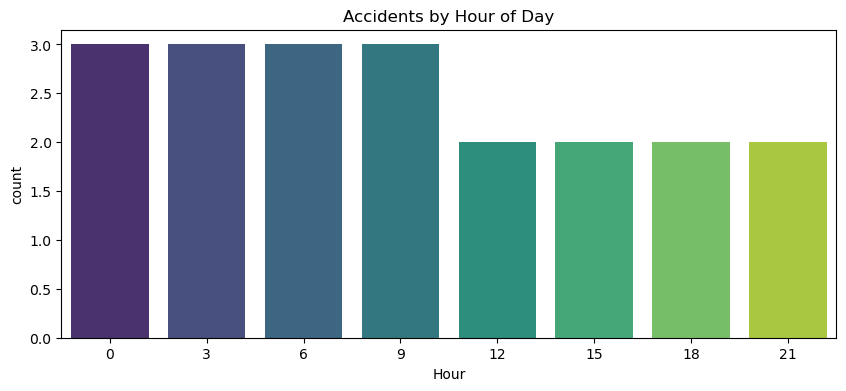

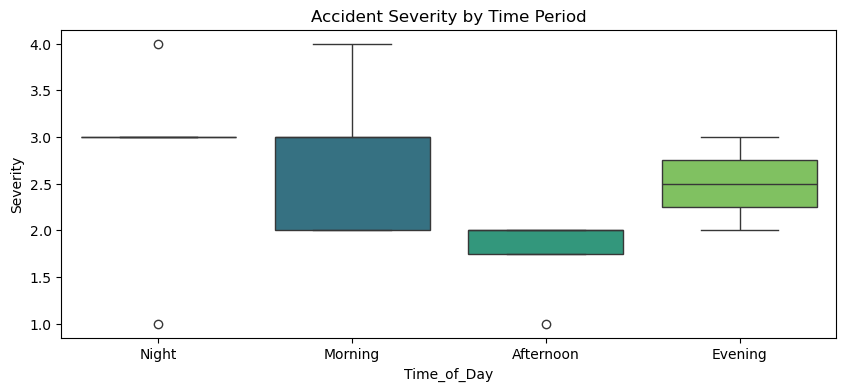

In [65]:
# 1. Hourly accident distribution
plt.figure(figsize=(10, 4))
sns.countplot(x='Hour', data=df, palette='viridis')
plt.title('Accidents by Hour of Day')
plt.savefig('hourly_accidents.png', dpi=300, bbox_inches='tight')

# 2. Severity by time of day
plt.figure(figsize=(10, 4))
sns.boxplot(x='Time_of_Day', y='Severity', data=df, palette='viridis')
plt.title('Accident Severity by Time Period')
plt.savefig('severity_by_time.png', dpi=300, bbox_inches='tight')
plt.show()

### Weather & Road Condition Analysis

C:\Users\priya\AppData\Local\Temp\ipykernel_40144\848660614.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weather_Condition', y='Severity', data=df,


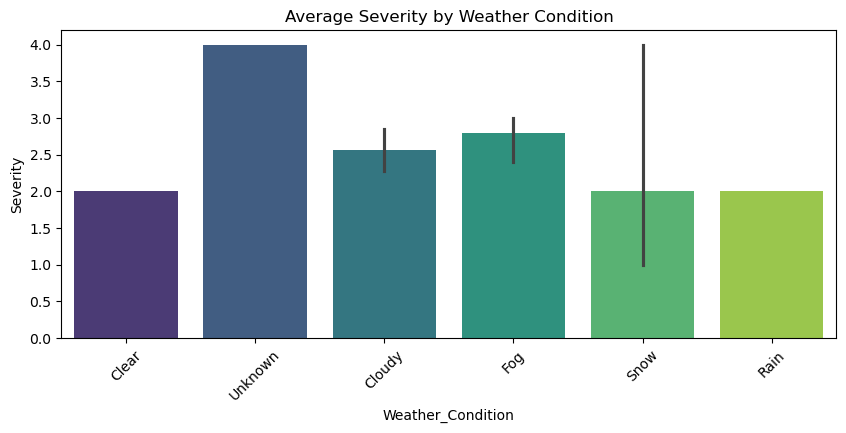

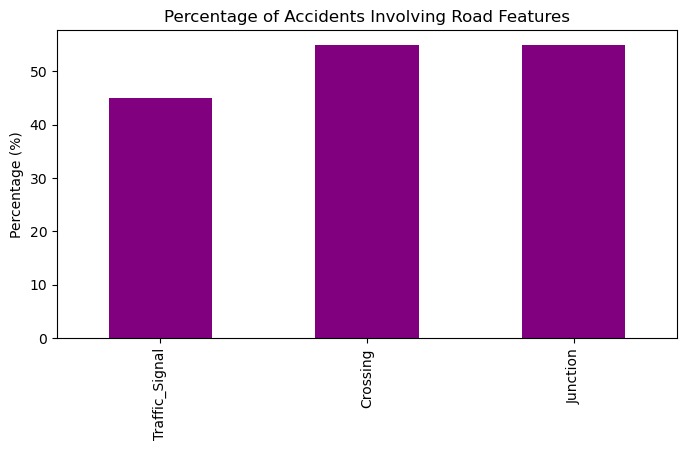

In [68]:
# 1. Weather impact
plt.figure(figsize=(10, 4))
sns.barplot(x='Weather_Condition', y='Severity', data=df, 
            estimator=np.mean, palette='viridis')
plt.title('Average Severity by Weather Condition')
plt.xticks(rotation=45)

# 2. Road features
plt.figure(figsize=(8, 4))
road_features = ['Traffic_Signal', 'Crossing', 'Junction']
(df[road_features].mean()*100).plot(kind='bar', color='purple')
plt.title('Percentage of Accidents Involving Road Features')
plt.ylabel('Percentage (%)')
plt.savefig('road_features.png', dpi=300, bbox_inches='tight')
plt.show()

### Hotspot Visualization

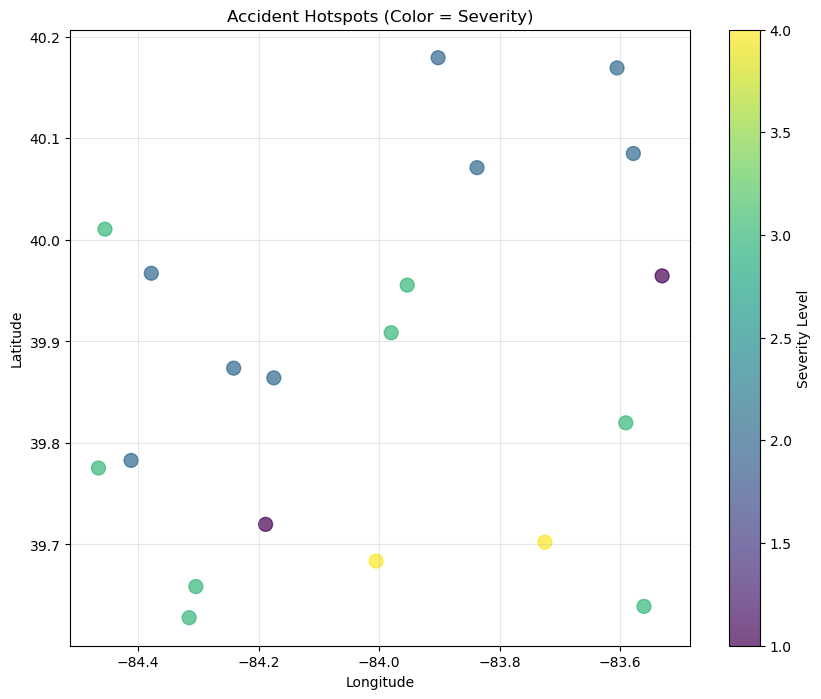

In [71]:
# 1. Interactive Folium map
m = folium.Map(location=[df['Start_Lat'].mean(), df['Start_Lng'].mean()], zoom_start=10)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Start_Lat'], row['Start_Lng']],
        radius=row['Severity']*3,
        popup=f"Severity: {row['Severity']} | {row['Weather_Condition']}",
        color='crimson',
        fill=True
    ).add_to(m)
m.save('interactive_hotspots.html')

# 2. Static heatmap
plt.figure(figsize=(10, 8))
plt.scatter(df['Start_Lng'], df['Start_Lat'], 
           c=df['Severity'], cmap='viridis', s=100, alpha=0.7)
plt.colorbar(label='Severity Level')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accident Hotspots (Color = Severity)')
plt.grid(True, alpha=0.3)
plt.savefig('static_hotspots.png', dpi=300, bbox_inches='tight')
plt.show()

### Key Findings & Recommendations

In [73]:
# Calculate statistics
peak_hour = df['Hour'].value_counts().idxmax()
worst_weather = df.groupby('Weather_Condition')['Severity'].mean().idxmax()
signal_pct = df['Traffic_Signal'].mean()*100

# Generate report
print(f"""
=== ANALYSIS RESULTS ===
1. Temporal Patterns:
   - Peak accident hour: {peak_hour}:00
   - Highest severity during: {df.groupby('Time_of_Day')['Severity'].mean().idxmax()}

2. Weather Impact:
   - Most dangerous condition: {worst_weather}
   - Clear vs Rain severity difference: {df[df['Weather_Condition']=='Rain']['Severity'].mean()/df[df['Weather_Condition']=='Clear']['Severity'].mean():.1f}x

3. Road Features:
   - Traffic signals present in {signal_pct:.0f}% of accidents
   - Junctions involved in {df['Junction'].mean()*100:.0f}% of cases

=== RECOMMENDATIONS ===
1. Increase patrols during {peak_hour}:00-{peak_hour+2}:00
2. Implement weather-specific speed limits
3. Audit traffic signals at hotspot locations
""")


=== ANALYSIS RESULTS ===
1. Temporal Patterns:
   - Peak accident hour: 0:00
   - Highest severity during: Night

2. Weather Impact:
   - Most dangerous condition: Unknown
   - Clear vs Rain severity difference: 1.0x

3. Road Features:
   - Traffic signals present in 45% of accidents
   - Junctions involved in 55% of cases

=== RECOMMENDATIONS ===
1. Increase patrols during 0:00-2:00
2. Implement weather-specific speed limits
3. Audit traffic signals at hotspot locations



C:\Users\priya\AppData\Local\Temp\ipykernel_40144\1637544365.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  - Highest severity during: {df.groupby('Time_of_Day')['Severity'].mean().idxmax()}
